# Results

In [1]:
import warnings

warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fmriprep_denoise.visualization import figures, tables, utils
from myst_nb import glue


path_root = utils.get_data_root()

strategy_order = list(utils.GRID_LOCATION.values())
group_order = {'ds000228': ['adult', 'child'], 'ds000030':['control', 'ADHD', 'bipolar', 'schizophrenia']}

## Level of motion in samples quitified by mean framewise displacement

In [2]:
from statsmodels.stats.weightstats import ttest_ind

for_plotting = {}

datasets = ['ds000228', 'ds000030']
baseline_groups = ['adult', 'control']
for dataset, baseline_group in zip(datasets, baseline_groups):
    _, data, groups = tables.get_descriptive_data(dataset, path_root)
    baseline = data[data['groups'] == baseline_group]
    for group in group_order[dataset]:
        compare = data[data['groups'] == group]
        glue(
            f'{dataset}_{group}_mean',
            compare['mean_framewise_displacement'].mean(),
        )
        glue(
            f'{dataset}_{group}_sd',
            compare['mean_framewise_displacement'].std(),
        )
        glue(
            f'{dataset}_{group}_n',
            compare.shape[0],
        )
        if group != baseline_group:
            t_stats, pval, df = ttest_ind(
                baseline['mean_framewise_displacement'],
                compare['mean_framewise_displacement'],
                usevar='unequal',
            )
            glue(f'{dataset}_t_{group}', t_stats)
            glue(f'{dataset}_p_{group}', pval)
            glue(f'{dataset}_df_{group}', df)
    for_plotting.update({dataset: data})

0.1881064928771293

0.09326558238655397

33

0.3726003847486127

0.28907597426004483

122

-5.9903509055012885

1.5099409407527793e-08

148.7509307996301

0.16539396277836882

0.13728009970205265

106

0.13593892525398768

0.07369320920150656

35

1.6142391760943855

0.10934439067687333

109.8534368991607

0.18701416426998788

0.11641072751651341

41

-0.9589448521743521

0.34029949800608195

85.21354291761574

0.21773189578184338

0.10865071777683155

30

-2.189718164596873

0.03259039280825782

57.86321439589898

We will firstly characterise motion through the mean framewise displacement of each sample and the sub-groups.
This report will serve as a reference point for understanding the remainder of the results.
In `ds000228`, there was a significant difference in motion during the scan captured by mean framewise displacement 
between the child 
(M = {glue:text}`ds000228_child_mean:.2f`, SD = {glue:text}`ds000228_child_sd:.2f`, n = {glue:text}`ds000228_child_n:i`)
and adult sample
(M = {glue:text}`ds000228_adult_mean:.2f`, SD = {glue:text}`ds000228_adult_sd:.2f`, n = {glue:text}`ds000228_adult_n:i`;
t({glue:text}`ds000228_df_child:.2f`) = {glue:text}`ds000228_t_child:.2f`, p = {glue:text}`ds000228_p_child:.3f`).
This is consistent with the existing literature.
In `ds000030`, the only patient group shows a difference comparing to the
control 
(M = {glue:text}`ds000030_control_mean:.2f`, SD = {glue:text}`ds000030_control_sd:.2f`, n = {glue:text}`ds000030_control_n:i`)
is the schizophrania group 
(M = {glue:text}`ds000030_schizophrenia_mean:.2f`, SD = {glue:text}`ds000030_schizophrenia_sd:.2f`, n = {glue:text}`ds000030_schizophrenia_n:i`;
t({glue:text}`ds000030_df_schizophrenia:.2f`) = {glue:text}`ds000030_t_schizophrenia:.2f`, p = {glue:text}`ds000030_p_schizophrenia:.3f`).
There was no difference between the control and ADHD group
(M = {glue:text}`ds000030_ADHD_mean:.2f`, SD = {glue:text}`ds000030_ADHD_sd:.2f`, n = {glue:text}`ds000030_ADHD_n:i`;
t({glue:text}`ds000030_df_ADHD:.2f`) = {glue:text}`ds000030_t_ADHD:.2f`, p = {glue:text}`ds000030_p_ADHD:.3f`),
or the bipolar group 
(M = {glue:text}`ds000030_bipolar_mean:.2f`, SD = {glue:text}`ds000030_bipolar_sd:.2f`, n = {glue:text}`ds000030_bipolar_n:i`;
t({glue:text}`ds000030_df_bipolar:.2f`) = {glue:text}`ds000030_t_bipolar:.2f`, p = {glue:text}`ds000030_p_bipolar:.3f`).
In conclusion, adult samples has lower mean framewise displacement than a youth sample.

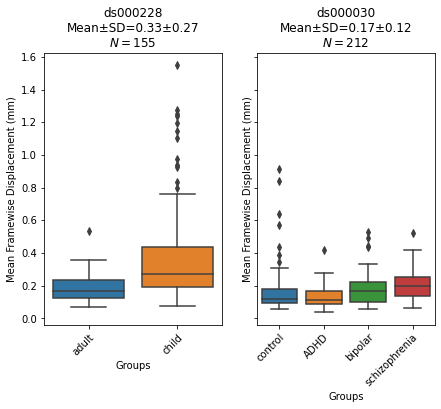

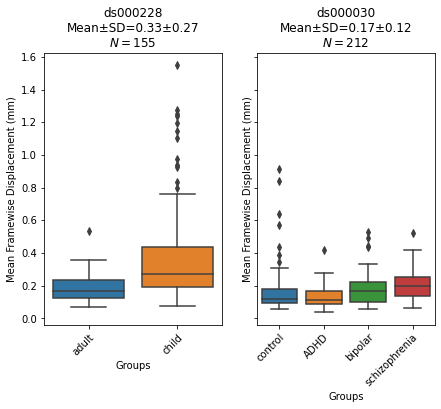

In [3]:
fig = plt.figure(figsize=(7, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(for_plotting, axs):
    df = for_plotting[dataset]
    mean_fd = df['mean_framewise_displacement'].mean()
    sd_fd = df['mean_framewise_displacement'].std()
    df = df.rename(
        columns={
            'mean_framewise_displacement': 'Mean Framewise Displacement (mm)',
            'groups': 'Groups'
        }
    )
    sns.boxplot(
        y='Mean Framewise Displacement (mm)', x='Groups', data=df, ax=ax,
        order=group_order[dataset]
    )
    ax.set_xticklabels(group_order[dataset], rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(
        f'{dataset}\nMean\u00B1SD={mean_fd:.2f}\u00B1{sd_fd:.2f}\n$N={df.shape[0]}$'
    )
# fig.suptitle("Mean framewise displacement per sub-sample")

glue('meanFD-fig', fig, display=False)

```{glue:figure} meanFD-fig
:figwidth: 800px
:name: "tbl:meanFD-fig"

Mean framewise displacement of each dataset.
We found young subjects has higher motion comparing to adults,
which is consistent with the pattern described in the literature.
Amongst psychiatric conditiontions, only the schizophrania group shows difference to the control group.
```

## The loss in temporal degrees of freedom in different strategies

The common analysis and denoising methods are based on linear reagression.
Using more nuisance regressors can capture additional sources of noise-related variance in the data and thus improve denoising.
However, this comes at the expense of a loss of temporal degrees of freedom for statistical inference in further analysis.
This is an important point to consider along side the denoising performance.

In fMRIPrep, high-pass filtering is done through discrete cosine-basis regressors, 
labled as `cosine_*` in fMRIPrep confounds output.
In the following section, the number of discrete cosine-basis regressor will be denoted as $c$. 
Depending on the length of the scan, the number of discrete cosine-basis regressors can differ ($c_{ds000228}=4$, $c_{ds000030}=3$). 
The `simple` and `srubbing`-based strategy are the strategy with a fixed number of degree of freedom loss.
`compcor` and `aroma`-based strategies shows variability depending on the number of noise compoenets detected.
In theory, `compcor6` should also report a fixed number of degree of freedom loss.
However, fMRIPrep outputs the compcor compoenents based on the 50% variance cut-off.
For some subjects the number of components could be lower than 6, hence the variability.

In {cite:t}`ciric_benchmarking_2017`, the equivalent `aroma` and `aroma+gsr` strategies were reported with 
a lower magnitude of loss in temporal degrees of freedom than `scrubbing` or `simple` strategies.
However, we did not observe this advantage is limited to sample with relatively low motion (i.e. adults).
When selecting denoising strategy, 
The two datasets used in the current benchmark both contained subjects with behaviours deviating from the healthy controls.
`ds000228` is comprised of adult healthy controls and children.
`ds000030` includes healthy controls and subjects with three different psychiatric conditions.
the loss in degrees of freedom `simple` ($26 + c$) and `simple+gsr` ($27 + c$) used the least amount of regressors in the general population.
Certain sub-sample uses less regressors with the `aroma` and `aroma+gsr` strategies.
The reason potentially lies in the implementation of ICA-AROMA. 
ICA-AROMA uses pretrained model on healthy subjects to select noise components {cite:p}`aroma`.

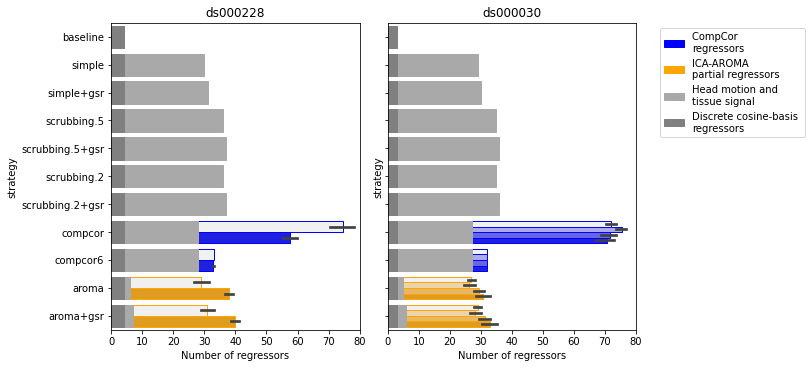

['adult', 'child']

['control', 'ADHD', 'bipolar', 'schizophrenia']

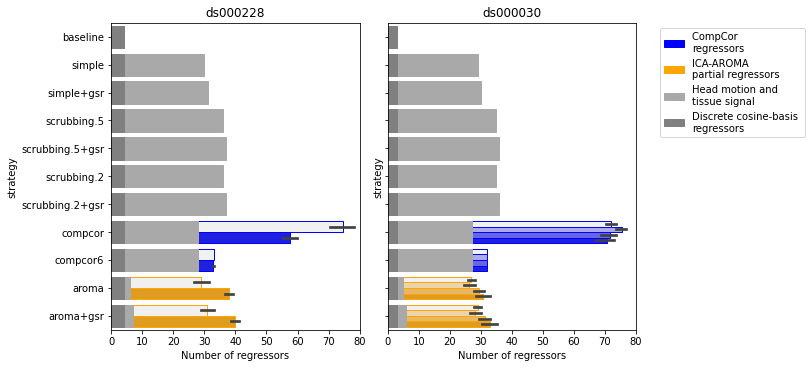

In [4]:
fig, ds_groups = figures.plot_dof_dataset(path_root)
glue(f'dof-fig', fig, display=False)
for ds, group in ds_groups:
    glue(f'group-order_{ds}', group, display=False)

```{glue:figure} dof-fig
:figwidth: 800px
:name: "tbl:dof-fig"

Loss in temporal degrees of freedom break down by groups.
`compcor` and `aroma`-based strategies shows variability depending on the number of noise compoenets detected.
The variability is broken down by groups.
From the lightest hue to the darkes, the order of the group in `ds000228` is:
{glue:}`group-order_ds000228`
From the lightest hue to the darkes, the order of the group in `ds000030` is:
{glue:}`group-order_ds000030`
```

To compare the loss in number of volumes from scrubbing base strategy across datasets,
we calculate the proportion of volume loss to number of volumes in a full scan.
`ds000228` includes child subjects and shows higher loss in volumes comparing to `ds000030` with adult subjects only.
This is consistent with the trend in the difference in mean framewise displacement,
and it fits the observation shown in literature {cite:p}`satterthwaite_impact_2012`.
In `ds000030`, we see the similar trend mirroring the mean framewise displacemnt results.
The schizophrania group shows the highest amount of volumes scrubbed,
followed by the bipolar group, and comparable results between the control group and ADHD group.
With a stringent 0.2 mm threshold, groups with high motion will loose on average close to half of the volumes.

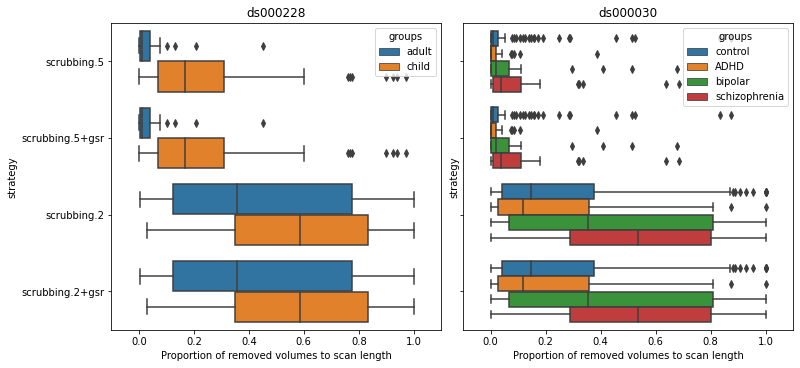

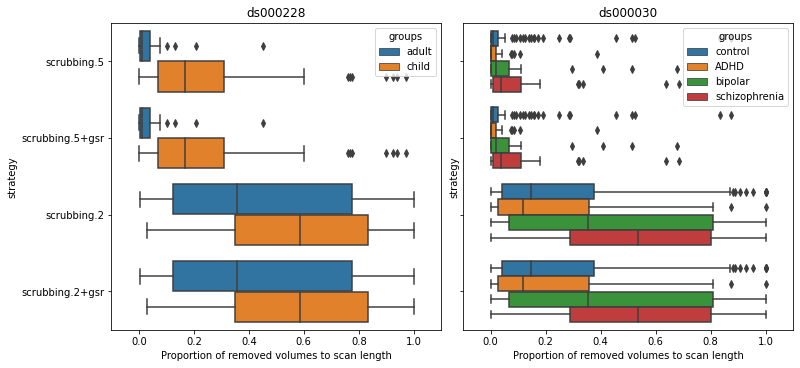

In [5]:
fig = figures.plot_vol_scrubbed_dataset(path_root)
glue(f'scrubbing-fig', fig, display=False)

```{glue:figure} scrubbing-fig
:figwidth: 800px
:name: "tbl:scrubbing-fig"

Loss in number of volumes in proportion to the full length of the scan, break down by groups in each dataset.
We can see the trend is similar to mean framewise displacement result. 

```

## Comparisons on the impacts of strategies on connectomes
<!-- Please advice on the threshold here -->
<!-- stringent -->
To evaluate the impact of denoising strategy on connectomes in a practical scenrio, 
we excluded subjects with high motion as such subjects would be normally excluded in data quality control stage 
(see section {ref}`framewise-displacement`). 

The two tables below are the demographic information of the datasets after
the automatic motion quality control.

In [6]:
from fmriprep_denoise.features.derivatives import get_qc_criteria

stringent = get_qc_criteria('stringent')
desc = tables.lazy_demographic('ds000228', path_root, **stringent)
desc = desc.style.set_table_attributes('style="font-size: 12px"')

glue('ds000228_scrubbed_desc', desc) 

,full sample,adult,child
count,75.000000,24.000000,51.000000
mean,12.222012,23.627500,6.854723
std,8.434903,4.107435,2.390175
min,3.594798,18.000000,3.594798
25%,5.475000,21.000000,5.070000
50%,8.590000,22.500000,7.000000
75%,20.000000,27.015000,9.020000
max,31.000000,31.000000,11.510000
n_female,38.000000,14.000000,24.000000


In [7]:
from fmriprep_denoise.visualization import tables

desc = tables.lazy_demographic('ds000030', path_root, **stringent)
desc = desc.style.set_table_attributes('style="font-size: 12px"')

glue('ds000030_scrubbed_desc', desc) 

,full sample,control,ADHD,bipolar,schizophrenia
count,168.000000,88.000000,32.000000,29.000000,19.000000
mean,31.714286,30.511364,32.281250,32.482759,35.157895
std,8.918220,8.202879,10.340133,8.274836,10.045802
min,21.000000,21.000000,21.000000,21.000000,22.000000
25%,24.000000,24.000000,24.000000,25.000000,27.000000
50%,29.000000,27.500000,28.000000,32.000000,33.000000
75%,39.000000,37.250000,40.000000,36.000000,45.500000
max,50.000000,50.000000,50.000000,48.000000,49.000000
n_female,79.000000,46.000000,14.000000,15.000000,4.000000


In [8]:
from statsmodels.stats.weightstats import ttest_ind

for_plotting = {}

datasets = ['ds000228', 'ds000030']
baseline_groups = ['adult', 'control']
for dataset, baseline_group in zip(datasets, baseline_groups):
    _, data, _ = tables.get_descriptive_data(dataset, path_root, **stringent)
    baseline = data[data['groups'] == baseline_group]
    for group in group_order[dataset]:
        compare = data[data['groups'] == group]
        glue(
            f'{dataset}_{group}_mean_qc',
            compare['mean_framewise_displacement'].mean(),
        )
        glue(
            f'{dataset}_{group}_sd_qc',
            compare['mean_framewise_displacement'].std(),
        )
        glue(
            f'{dataset}_{group}_n_qc',
            compare.shape[0],
        )
        if group != baseline_group:
            t_stats, pval, df = ttest_ind(
                baseline['mean_framewise_displacement'],
                compare['mean_framewise_displacement'],
                usevar='unequal',
            )
            glue(f'{dataset}_t_{group}_qc', t_stats)
            glue(f'{dataset}_p_{group}_qc', pval)
            glue(f'{dataset}_df_{group}_qc', df)
    for_plotting.update({dataset: data})

0.1462397403408233

0.044565864996593665

24

0.1713232972424761

0.047582849871793745

51

-2.22449678497562

0.030856856649758648

47.94871226550252

0.11977437814582852

0.03742202385446908

88

0.11942202067597785

0.04578950577159043

32

0.03904613880168271

0.9690193375254951

46.90135041680077

0.1306404021392316

0.04980262339356017

29

-1.0788551403681448

0.2872874041287868

38.954983333738376

0.15526774361667847

0.051810060780389404

19

-2.830950730446425

0.009666382997222738

22.2251244773367

We again checked the difference in mean framewise displacement of each sample and the sub-groups.
In `ds000228`, there was still a significant difference in motion during the scan captured by mean framewise displacement 
between the child 
(M = {glue:text}`ds000228_child_mean_qc:.2f`, SD = {glue:text}`ds000228_child_sd_qc:.2f`, n = {glue:text}`ds000228_child_n_qc:i`)
and adult sample
(M = {glue:text}`ds000228_adult_mean_qc:.2f`, SD = {glue:text}`ds000228_adult_sd_qc:.2f`, n = {glue:text}`ds000228_adult_n_qc:i`,
t({glue:text}`ds000228_df_child_qc:.2f`) = {glue:text}`ds000228_t_child_qc:.2f`, p = {glue:text}`ds000228_p_child_qc:.3f`).
In `ds000030`, the only patient group shows a difference comparing to the control 
(M = {glue:text}`ds000030_control_mean_qc:.2f`, SD = {glue:text}`ds000030_control_sd_qc:.2f`, n = {glue:text}`ds000030_control_n_qc:i`)
is still the schizophrania group 
(M = {glue:text}`ds000030_schizophrenia_mean_qc:.2f`, SD = {glue:text}`ds000030_schizophrenia_sd_qc:.2f`, n = {glue:text}`ds000030_schizophrenia_n_qc:i`;
t({glue:text}`ds000030_df_schizophrenia_qc:.2f`) = {glue:text}`ds000030_t_schizophrenia_qc:.2f`, p = {glue:text}`ds000030_p_schizophrenia_qc:.3f`).
There was no difference between the control and ADHD group
(M = {glue:text}`ds000030_ADHD_mean_qc:.2f`, SD = {glue:text}`ds000030_ADHD_sd:.2f`, n = {glue:text}`ds000030_ADHD_n_qc:i`;
t({glue:text}`ds000030_df_ADHD_qc:.2f`) = {glue:text}`ds000030_t_ADHD_qc:.2f`, p = {glue:text}`ds000030_p_ADHD_qc:.3f`),
or the bipolar group 
(M = {glue:text}`ds000030_bipolar_mean_qc:.2f`, SD = {glue:text}`ds000030_bipolar_sd_qc:.2f`, n = {glue:text}`ds000030_bipolar_n_qc:i`;
t({glue:text}`ds000030_df_bipolar_qc:.2f`) = {glue:text}`ds000030_t_bipolar_qc:.2f`, p = {glue:text}`ds000030_p_bipolar_qc:.3f`).
In conclusion, adult samples has lower mean framewise displacement than a youth sample.

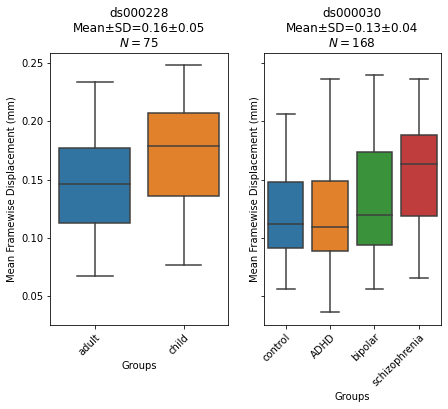

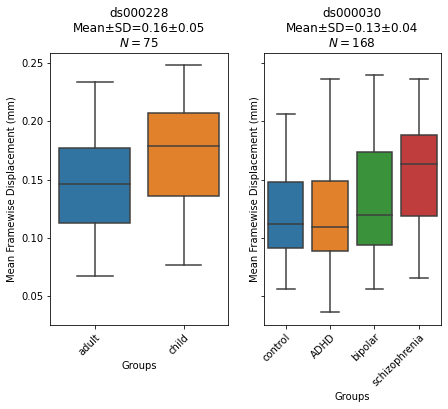

In [9]:
datasets = ['ds000228', 'ds000030']
for dataset in datasets:
    _, data, _ = tables.get_descriptive_data(dataset, path_root, **stringent)
    for_plotting.update({dataset: data})

fig = plt.figure(figsize=(7, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(for_plotting, axs):
    df = for_plotting[dataset]
    mean_fd = df['mean_framewise_displacement'].mean()
    sd_fd = df['mean_framewise_displacement'].std()
    df = df.rename(
        columns={
            'mean_framewise_displacement': 'Mean Framewise Displacement (mm)',
            'groups': 'Groups'
        }
    )
    sns.boxplot(
        y='Mean Framewise Displacement (mm)', x='Groups', data=df, ax=ax,
        order=group_order[dataset]
    )
    ax.set_xticklabels(group_order[dataset], rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(
        f'{dataset}\nMean\u00B1SD={mean_fd:.2f}\u00B1{sd_fd:.2f}\n$N={df.shape[0]}$'
    )
# fig.suptitle("Mean framewise displacement per sub-sample")

glue('meanFD_cleaned-fig', fig, display=False)

```{glue:figure} meanFD_cleaned-fig
:figwidth: 800px
:name: "tbl:meanFD_cleaned-fig"
```

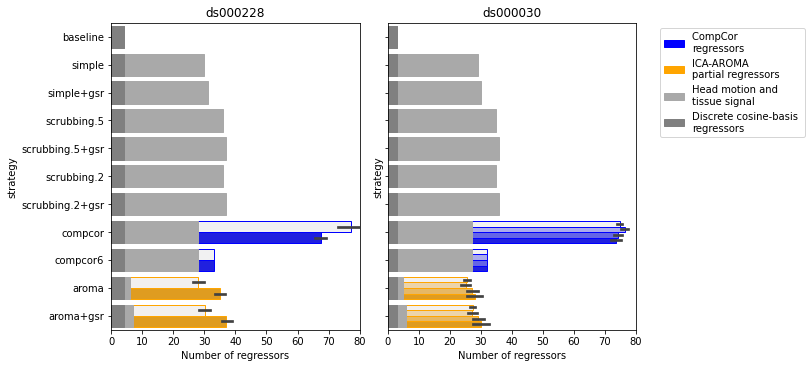

['adult', 'child']

['control', 'ADHD', 'bipolar', 'schizophrenia']

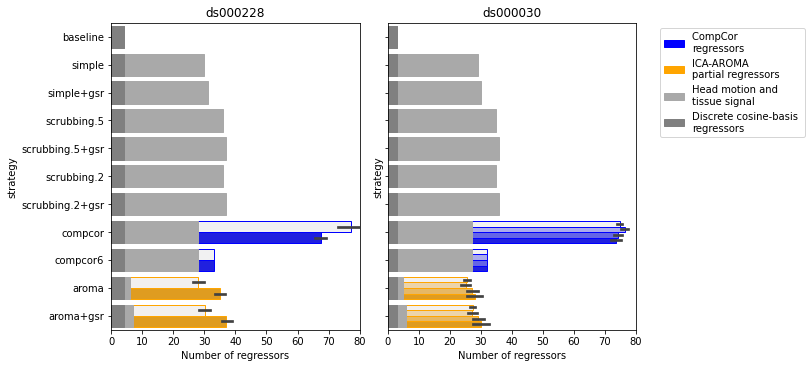

In [10]:
fig, ds_groups = figures.plot_dof_dataset(path_root, **stringent)
glue(f'dof-fig_cleaned', fig, display=False)
for ds, group in ds_groups:
    glue(f'group-order_{ds}_cleaned', group, display=False)

As for the loss in temporal degrees of freedom break down by groups, the trend 
did not differ from the full sample, as seen in the two graphs below.

```{glue:figure} dof-fig_cleaned
:figwidth: 800px
:name: "tbl:dof-fig_cleaned"

Loss in temporal degrees of freedom break down by groups after quality control,
after applying the stringent quality control threshold.
From the lightest hue to the darkes, the order of the group in `ds000228` is:
{glue:}`group-order_ds000228_cleaned`
From the lightest hue to the darkes, the order of the group in `ds000030` is:
{glue:}`group-order_ds000030_cleaned`
```

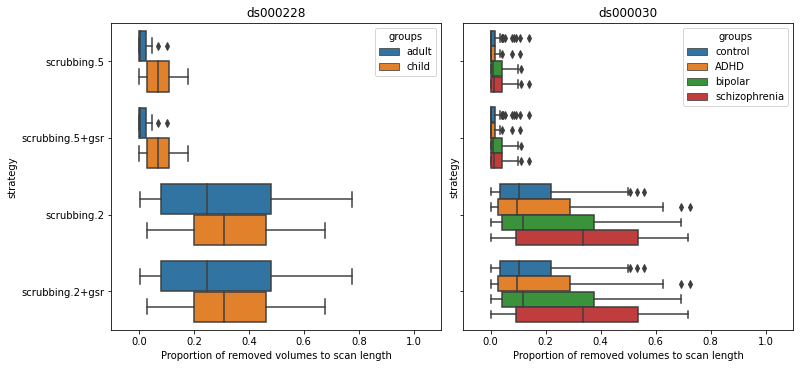

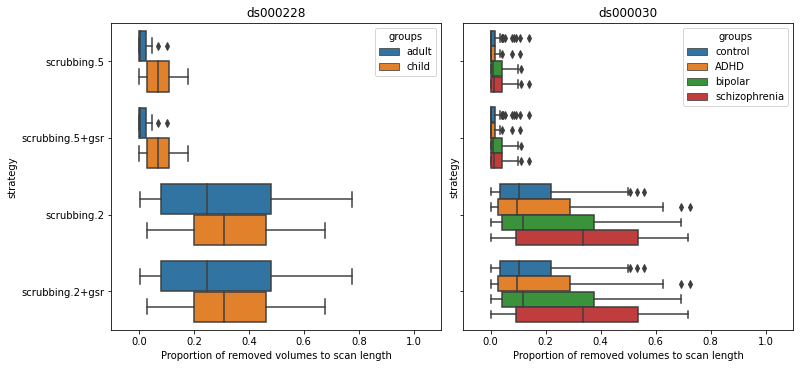

In [11]:
fig = figures.plot_vol_scrubbed_dataset(path_root, **stringent)
glue(f'scrubbing-fig_cleaned', fig, display=False)

```{glue:figure} scrubbing-fig_cleaned
:figwidth: 800px
:name: "tbl:scrubbing-fig_cleaned"

Loss in number of volumes in proportion to the full length of the scan after quality control, 
break down by groups in each dataset,
after applying the stringent quality control threshold.
We can see the trend is similar to mean framewise displacement result. 

```

In the next section, we report the three functional connectivity based metrics and break down the effect on each dataset.
We combined all atlases in the current report as the trends in each atlas are similar.
For breakdown of each metric by atlas, 
please see the supplemental material for 
[`ds000228`](../supplementary_materials/report_ds000228.md) and [`ds000030`](../supplementary_materials/report_ds000030.md).

### QC-FC

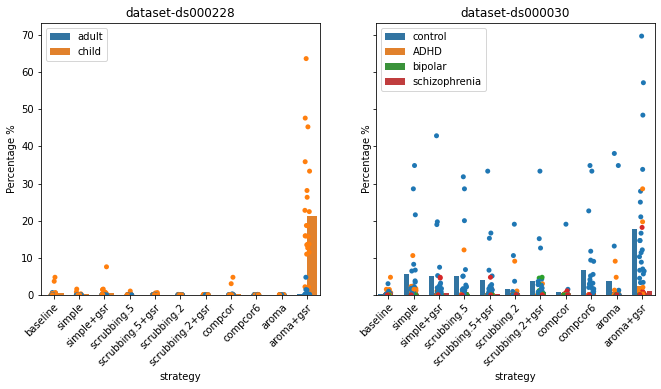

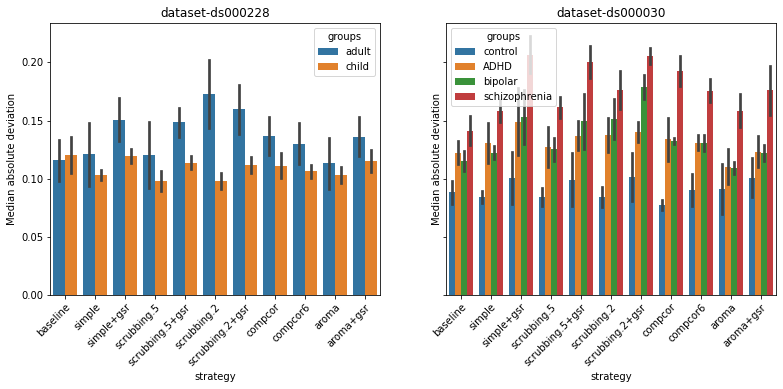

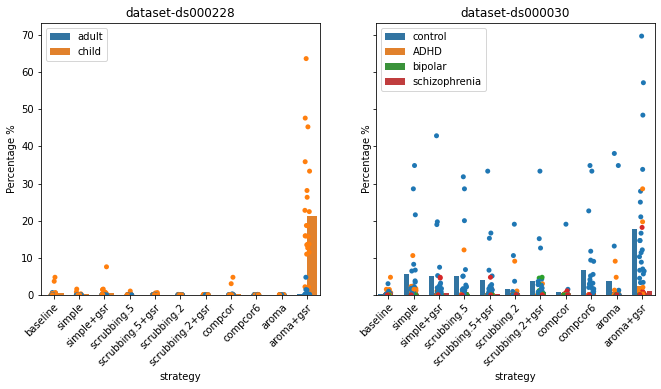

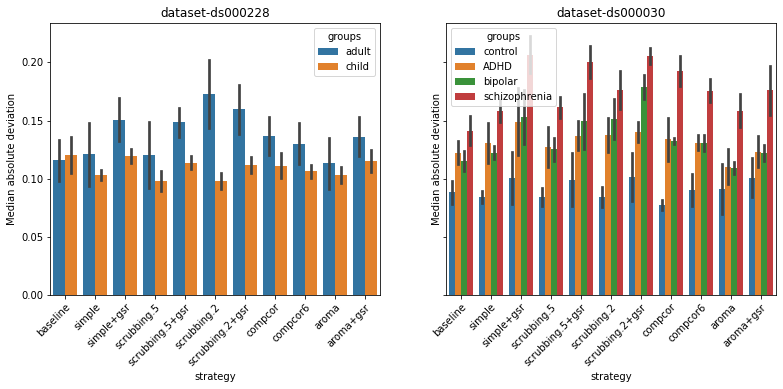

In [12]:
path_ds000228 = path_root / "dataset-ds000228_summary.tsv"
path_ds000030 =  path_root / "dataset-ds000030_summary.tsv"
ds000228 = pd.read_csv(path_ds000228, sep='\t', index_col=[0, 1], header=[0, 1])
ds000030  = pd.read_csv(path_ds000030, sep='\t', index_col=[0, 1], header=[0, 1])

data = pd.concat({'ds000228': ds000228, 'ds000030':ds000030}, names=['datasets'])
id_vars = data.index.names

# Plotting
data_long = data['qcfc_fdr_significant'].reset_index().melt(id_vars=id_vars, value_name='Percentage %')
data_long = data_long.set_index(keys=['datasets'])
fig = plt.figure(figsize=(11, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(['ds000228', 'ds000030'], axs):
    df = data_long.loc[dataset, :]
    sns.barplot(
        y='Percentage %', x='strategy', hue='groups', data=df, ax=ax,
        order=strategy_order, ci=None,
        # hue_order=['full_sample']
        hue_order=group_order[dataset]
    )
    sns.stripplot(y='Percentage %', x='strategy', hue='groups', data=df, ax=ax, 
                  order=strategy_order, hue_order=group_order[dataset])
    ax.set_xticklabels(strategy_order, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(f'dataset-{dataset}')
    # Improve the legend
    handles, labels = ax.get_legend_handles_labels()
    lgd_idx = len(group_order[dataset])
    ax.legend(handles[lgd_idx:], labels[lgd_idx:])

glue('qcfc_fdr_significant', fig, display=False)


data_long = data['qcfc_mad'].reset_index().melt(id_vars=id_vars, value_name='Median absolute deviation')
data_long = data_long.set_index(keys=['datasets'])
fig = plt.figure(figsize=(13, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(['ds000228', 'ds000030'], axs):
    df = data_long.loc[dataset, :]
    sns.barplot(
        y='Median absolute deviation', x='strategy', hue='groups', data=df, ax=ax,
        order=strategy_order, ci='sd',
        # hue_order=['full_sample']
        hue_order=group_order[dataset]
    )
    ax.set_xticklabels(strategy_order, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(f'dataset-{dataset}')
glue('qcfc_mad', fig, display=False)

With good quality data, most denoising methonds reduce the corelation between functional connectivity and mean framewise displacement,
accessed by the QC-FC measure.
`ds000030` consists of adult sample only.
All denoisng strategies aside from `aroma+gsr` eliminate the impact of motion.
The variablilty in the healthy control is potentially driven by a larger sample than the rest.
When looking at the median absolute deviations, the schizophrania group still retains higher impact of motion than the remaining sample.
In `ds000228`, all strategies, including the baseline, 
shows motion remains in close to 0% of the connectivity edges.
`aroma+gsr` performs worse than the baseline in the child sample.
The meduan absolute deviation of QC-FC are all similar to the baseline. 


```{glue:figure} qcfc_fdr_significant
:figwidth: 800px
:name: "tbl:qcfc_fdr_significant"

Percentage of edges significantly correlating with mean framewise displacement false-discovery-rate corrected, summarised across all atlas of choices.
```

```{glue:figure} qcfc_mad
:figwidth: 800px
:name: "tbl:qcfc_mad"

Median absolute deviation of the correlations between connectivity edges and mean framewise displacement, summarised across all atlas of choices.
Lower value indicates less residual effect of motion after denoising.
```


### Distance-dependent of motion after denoising

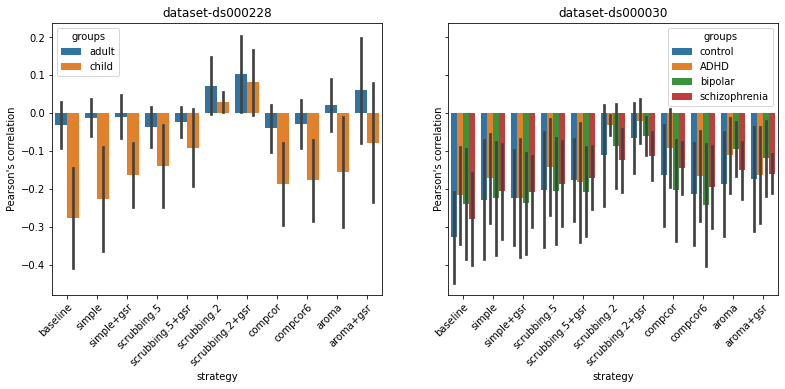

In [13]:
data_long = data['corr_motion_distance'].reset_index().melt(id_vars=id_vars, value_name='Pearson\'s correlation')
data_long = data_long.set_index(keys=['datasets'])
fig = plt.figure(figsize=(13, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(['ds000228', 'ds000030'], axs):
    df = data_long.loc[dataset, :]
    sns.barplot(
        y='Pearson\'s correlation', x='strategy', hue='groups', data=df, ax=ax,
        order=strategy_order, ci='sd', 
        # hue_order=['full_sample']
        hue_order=group_order[dataset]
    )
    ax.set_xticklabels(strategy_order, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(f'dataset-{dataset}')

Ideally, a denoising strategy should leave no residual association between QC-FC and interregional distance.
No strategy can eliminate the correlation between motion and short range connectivity edges.
In both datasets, we see all strategies reduces the magnitude of coreelation between distance and motion combaring to the baseline.
We observed a trend that strategy `scrubbing.2` and `scrubbing.2+gsr` are the closest in reducing the correlation to 0 between distance and motion, followed by `aroma` and `aroma+gsr`.
This trend is similar to the results reported in {cite:t}`ciric_benchmarking_2017`.

### Network modularity

The average network modularity after denoising shows that the inclusion of global signal regressors increases the modularity in both datasets. 
The correlation between motion and network modularity is less conclusive.
In `ds000228`, we first see the big differences between the adult and child sample.
Generally, the denoising strategies reduced the correlation motion and network modularity more in the adult sample than the child sample.  
In both samples, `aroma` reduced the the correlation the most, followed by the baseline and the `simple` strategy.
In `ds000030`, the schizophrania sample still showed a high correlation between modularity and motion.
For the control group, `aroma`, `aroma+gsr`, `compcor6`, and `simple` all brings the correlation between modularity and motion close to 0.
The baseline along performs better than the remainders.
For ADHD and bipolar group, `compcor` was the best performing strategy and performed better than baseline.
`aroma` was the second best overall, however, it performed on similar level comparing to the baseline.

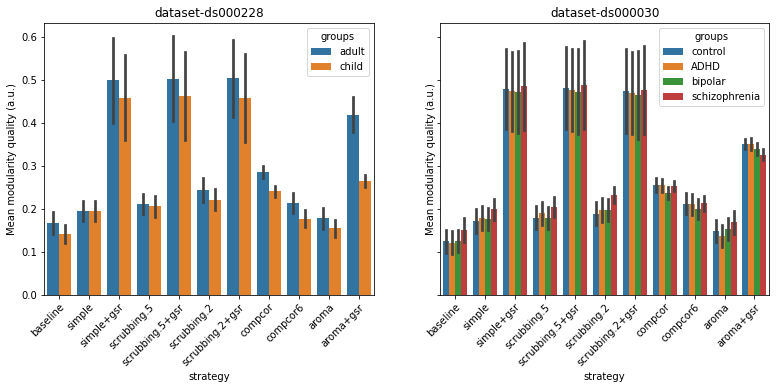

In [14]:
data_long = data['modularity'].reset_index().melt(id_vars=id_vars, value_name='Mean modularity quality (a.u.)')
data_long = data_long.set_index(keys=['datasets'])
fig = plt.figure(figsize=(13, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(['ds000228', 'ds000030'], axs):
    df = data_long.loc[dataset, :]
    sns.barplot(
        y='Mean modularity quality (a.u.)', x='strategy', hue='groups', data=df, ax=ax,
        order=strategy_order, ci='sd', 
        # hue_order=['full_sample']
        hue_order=group_order[dataset]
    )
    ax.set_xticklabels(strategy_order, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(f'dataset-{dataset}')

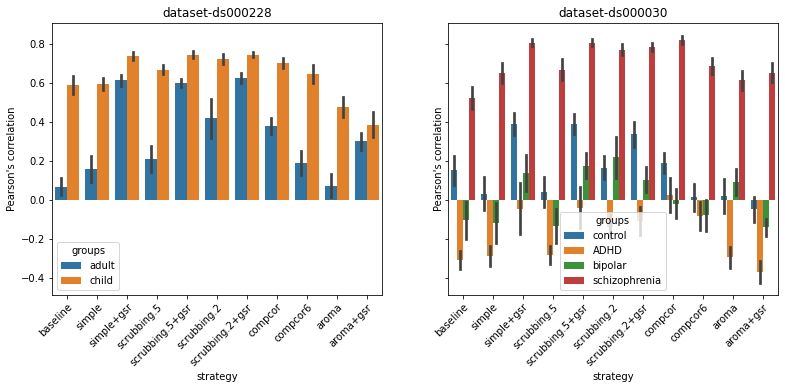

In [15]:
data_long = data['corr_motion_modularity'].reset_index().melt(id_vars=id_vars, value_name='Pearson\'s correlation')
data_long = data_long.set_index(keys=['datasets'])
fig = plt.figure(figsize=(13, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(['ds000228', 'ds000030'], axs):
    df = data_long.loc[dataset, :]
    sns.barplot(
        y='Pearson\'s correlation', x='strategy', hue='groups', data=df, ax=ax,
        order=strategy_order, ci='sd',
        # hue_order=['full_sample']
        hue_order=group_order[dataset]
    )
    ax.set_xticklabels(strategy_order, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(f'dataset-{dataset}')